**INTRODUCTION :**

This Notebook helps beginners visualize the Decision Boundaries for various classifiers.

This Notebook covers Decision Boundary Visualization of below classifiers:

**CLASSIFIERS :**
1. Logistic_Regression
2. K_Nearest_Neighbors
3. Support_Vector_Machines
4. Decision_Trees
5. Random_Forest
6. Extra_Trees
7. Ada_Boost
8. Gradient_Boost

Please do upvote if you find this helpful.

Suggestions are welcome :)

In [78]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import re
import time
import math
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#import classifiers from sklearn
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import warnings
warnings.filterwarnings('ignore')


# Any results you write to the current directory are saved as output.

**LOADING DATA :**

The first step is to read the data from the CSV file using pandas.

The current data_type is data frame. Difference between data frame and matrix is that data frame can store strings, numbers etc, whereas matrices can only store numbers.

In [79]:
train_data = pd.read_csv('D:\KULIAH/Semester 5/PM/train.csv')
test_data = pd.read_csv('D:\KULIAH/Semester 5/PM/test.csv')
train_data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


**FEATURE ENGINEERING:**

Thanks to the author of https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

Do check it out for more details on Feature Engineering.

The author explains detailed description of how to extract features from the dataset.

In [80]:
full_data = [train_data, test_data]

# Feature that tells whether a passenger had a cabin on the Titanic
train_data['Has_Cabin'] = train_data["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test_data['Has_Cabin'] = test_data["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train_data['Fare'].median())
train_data['CategoricalFare'] = pd.qcut(train_data['Fare'], 4,duplicates='drop')
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train_data['CategoricalAge'] = pd.cut(train_data['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    # Mapping titles
    title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "Rare": 4}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare']                               = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare']                                  = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age']                          = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4
 
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']#'Parch','Fare','Embarked','IsAlone']
train_data = train_data.drop(drop_elements, axis = 1)
train_data = train_data.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test_data  = test_data.drop(drop_elements, axis = 1)
train_data.head(2)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,0
1,1,1,0,2,0,3,1,1,2,0,2


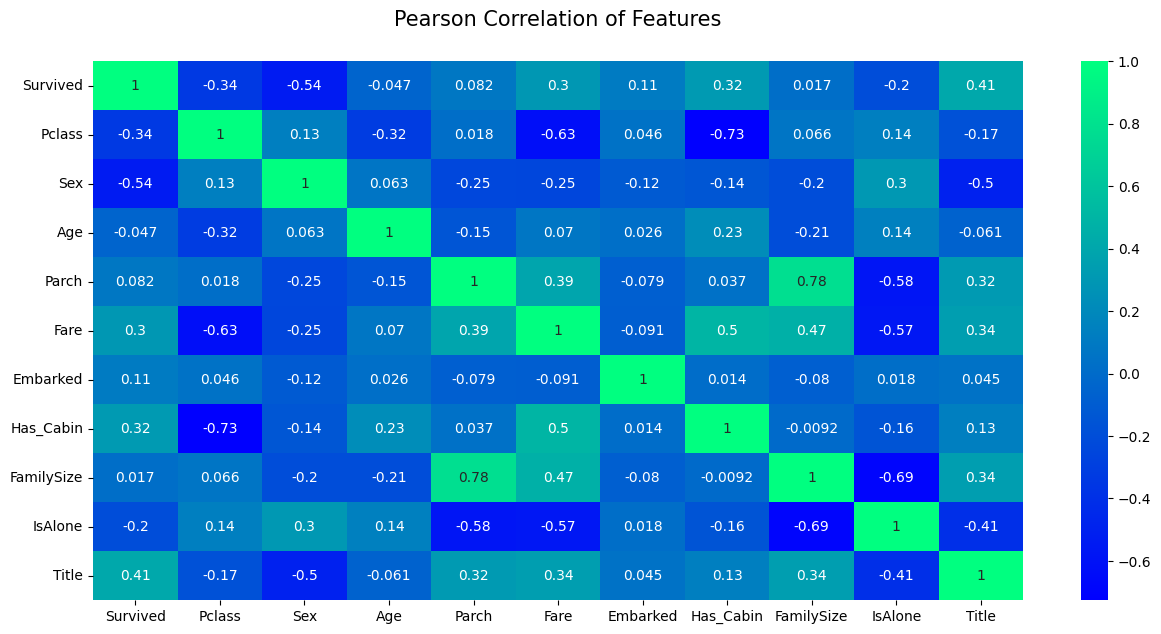

In [81]:
plt.figure(figsize=(15,7)) 
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_data.corr(),annot=True,cmap=plt.cm.winter) #draws  heatmap with input as the correlation matrix calculted by(iris.corr())
plt.show()

In [82]:
def plot(X_reduced,y,y_predict,title,f,axs):
    # create meshgrid
    #plot the negative points and positive points
    axs.set_title(title,fontsize=20)
    neg_val1 = X_reduced[np.where(y == 0), 0]
    neg_val2 = X_reduced[np.where(y == 0), 1]
    pos_val1 = X_reduced[np.where(y == 1), 0]
    pos_val2 = X_reduced[np.where(y == 1), 1]
    resolution = 500 # 100x100 background pixels
    X2d_xmin, X2d_xmax = np.min(X_reduced[:,0]), np.max(X_reduced[:,0])
    X2d_ymin, X2d_ymax = np.min(X_reduced[:,1]), np.max(X_reduced[:,1])
    xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

    # approximate Voronoi tesselation on resolution x resolution grid using 1-NN
    background_model = KNeighborsClassifier(n_neighbors=1).fit(X_reduced, y_predict) 
    voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
    voronoiBackground = voronoiBackground.reshape((resolution, resolution))

    #plot
    axs.contourf(xx, yy, voronoiBackground)
    l1 = axs.scatter(neg_val1, neg_val2, marker='o', c='red')
    l2 = axs.scatter(pos_val1, pos_val2, marker='x', c='green')
    f.legend((l1, l2), ('Not_Survived', 'Survived'), 'upper left',fontsize=15)

In [83]:
X = train_data.drop(['Survived'], axis =1)
y = train_data['Survived']
X_test = test_data
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size = 0.1)# in this our main data is split into train and test
# the attribute test_size=0.1 splits the data into 90% and 10% ratio. train=90% and test=10%
y_train = np.reshape(y_train,-1)
y_val = np.reshape(y_val,-1)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Test data shape: ', X_val.shape)
print('Test labels shape: ', y_val.shape)

Train data shape:  (801, 10)
Train labels shape:  (801,)
Test data shape:  (90, 10)
Test labels shape:  (90,)


In [86]:
mean = np.mean(X_train, axis=0,dtype=np.int64)
std = np.std(X_train, axis=0)
X_train -= mean
X_train = X_train/std
X_val -= mean
X_val = X_val/std
X_test -= mean
X_test = X_test/std

ValueError: the 'dtype' parameter is not supported in the pandas implementation of mean()

**DATA VISUALIZATION :**

**Use PCA to reduce the dimensions to 2 features.**

In [87]:
from sklearn.decomposition import TruncatedSVD
X_train_reduced = TruncatedSVD(n_components=2, random_state=0).fit_transform(X_train)
X_val_reduced = TruncatedSVD(n_components=2, random_state=0).fit_transform(X_val)

**VISUALIZING TRAIN & VALIDATION DATA : **

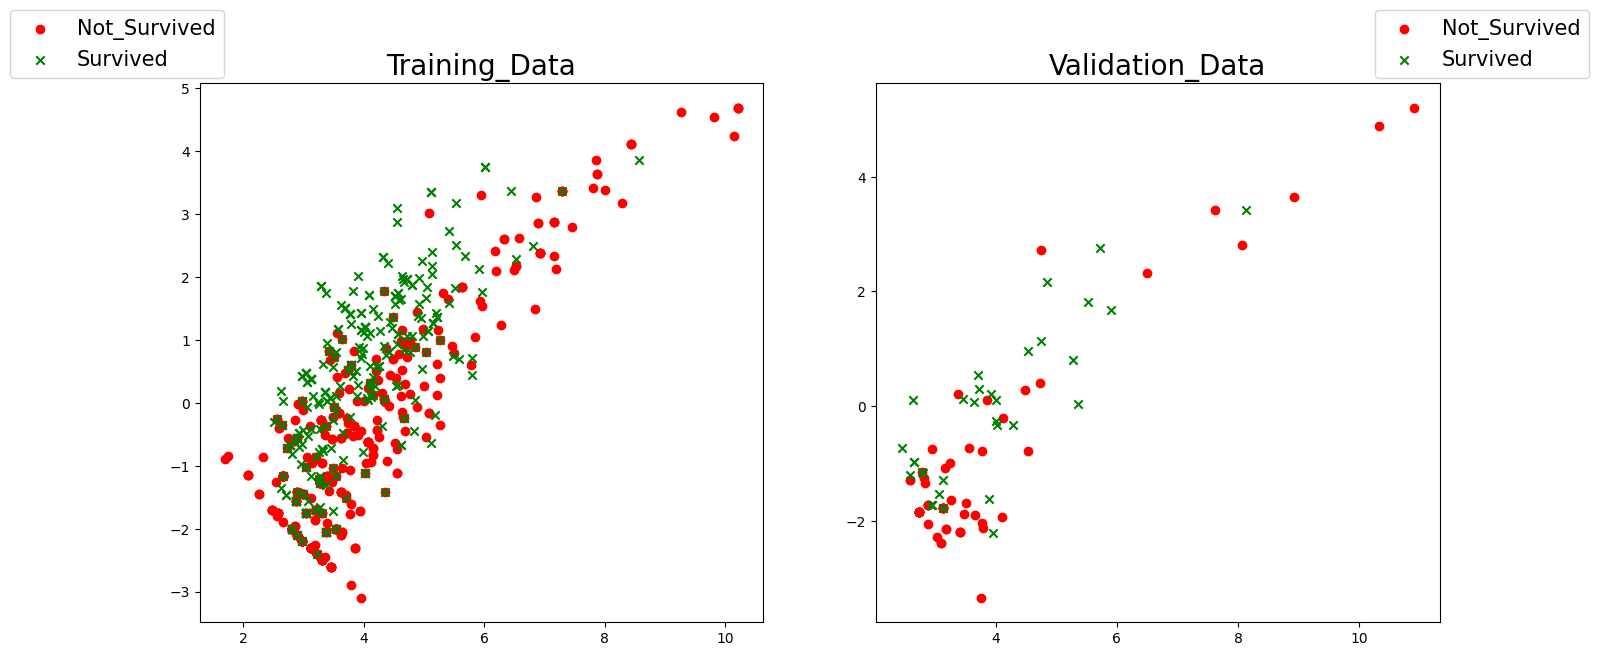

In [88]:
#plot the negative points and positive points
f, axs = plt.subplots(1,2,figsize=(16,7))
axs[0].set_title('Training_Data',fontsize=20)
l1 = axs[0].scatter(X_train_reduced[np.where(y_train == 0), 0], X_train_reduced[np.where(y_train == 0), 1], marker='o', c='red')
l2 = axs[0].scatter(X_train_reduced[np.where(y_train == 1), 0], X_train_reduced[np.where(y_train == 1), 1], marker='x', c='green')
f.legend((l1, l2), ('Not_Survived', 'Survived'), 'upper left',fontsize=15)
axs[1].set_title('Validation_Data',fontsize=20)
l3 = axs[1].scatter(X_val_reduced[np.where(y_val == 0), 0], X_val_reduced[np.where(y_val == 0), 1], marker='o', c='red')
l4 = axs[1].scatter(X_val_reduced[np.where(y_val == 1), 0], X_val_reduced[np.where(y_val == 1), 1], marker='x', c='green')
f.legend((l3, l4), ('Not_Survived', 'Survived'), 'upper right',fontsize=15)

In [89]:
columns = ['Train_Accuracy','Validation_Accuracy']
index = ['Logistic_Regression','KNN','SVM','Decision_Tree','Random_Forest','Extra_Trees','Ada_Boost','Gradient_Boost']
data = np.zeros((8,2))

In [90]:

svm = svm.SVC(kernel='rbf', random_state=0, gamma=.10, C=1.0).fit(X_train, y_train)
DT = DecisionTreeClassifier().fit(X_train,y_train)
RF = RandomForestClassifier(n_estimators=500, max_depth=None,min_samples_split=2, random_state=0).fit(X_train,y_train)


**DECISION_BOUNDARIES :**

**DECISION_TREES :**

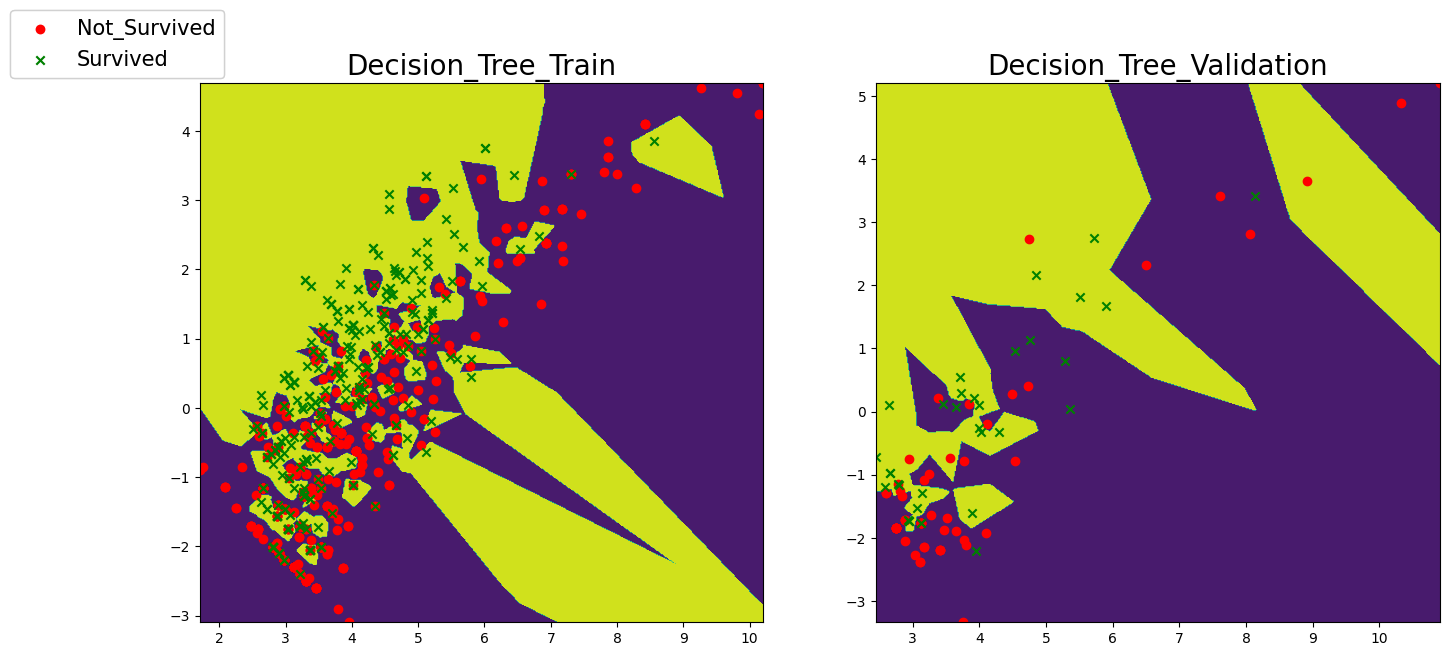

In [91]:
f, axs = plt.subplots(1,2,figsize=(16,7))
plot(X_train_reduced,y_train,DT.predict(X_train),'Decision_Tree_Train',f,axs[0])
plot(X_val_reduced,y_val,DT.predict(X_val),'Decision_Tree_Validation',f,axs[1])

**RANDOM_FOREST :**

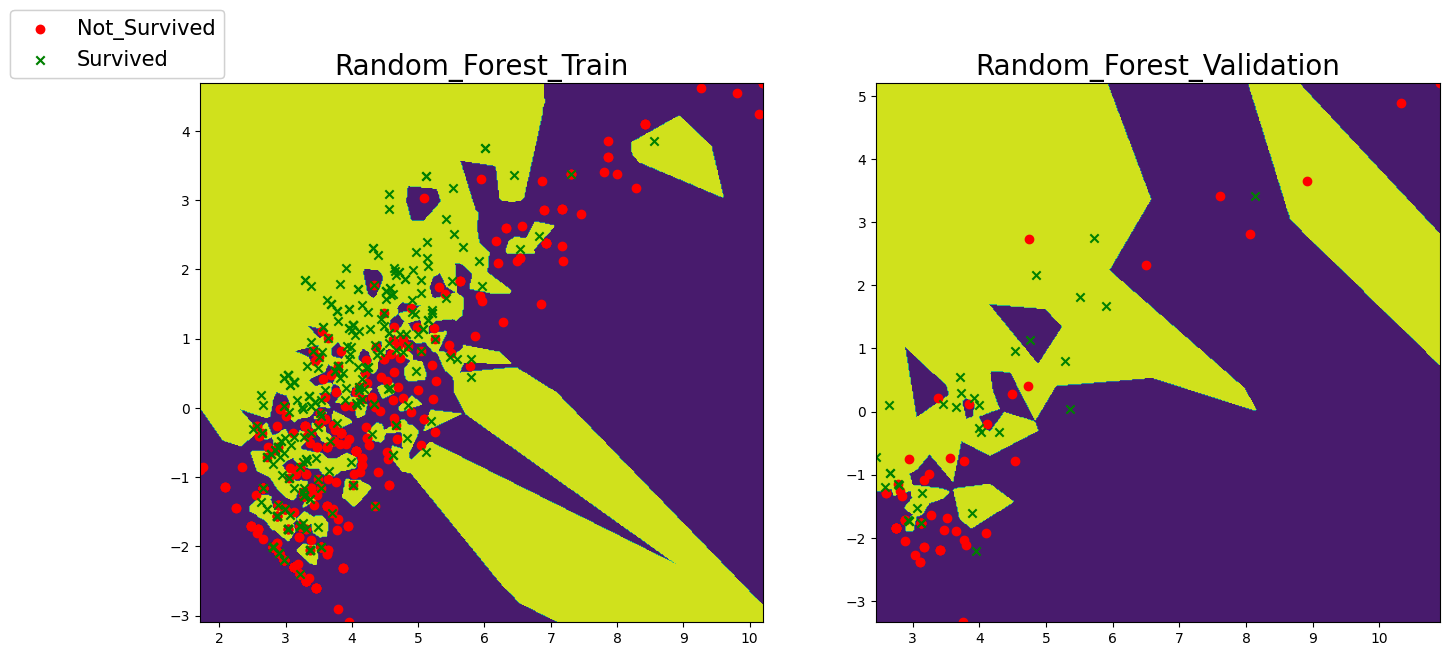

In [92]:
f, axs = plt.subplots(1,2,figsize=(16,7))
plot(X_train_reduced,y_train,RF.predict(X_train),'Random_Forest_Train',f,axs[0])
plot(X_val_reduced,y_val,RF.predict(X_val),'Random_Forest_Validation',f,axs[1])

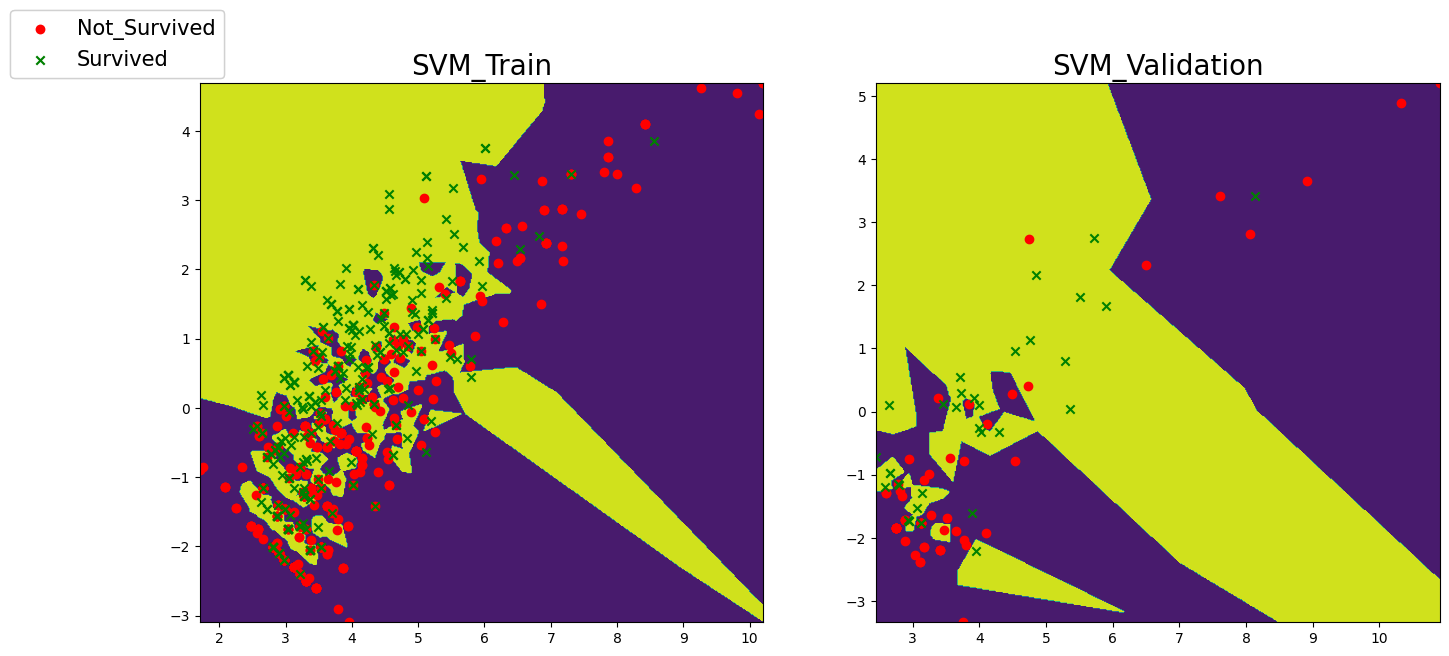

In [93]:
f, axs = plt.subplots(1,2,figsize=(16,7))
plot(X_train_reduced,y_train,svm.predict(X_train),'SVM_Train',f,axs[0])
plot(X_val_reduced,y_val,svm.predict(X_val),'SVM_Validation',f,axs[1])

In [94]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import regularizers

In [95]:
classifier = Sequential()
# 1st hidden layer
classifier.add(Dense(8, activation='relu', kernel_initializer='uniform', input_dim=7))
# 2nd hidden layer
classifier.add(Dense(8, activation='relu', kernel_initializer='random_normal'))
# Output Layer/ third layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

In [96]:
# Compiling the neural network
classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

In [97]:
NN = classifier.fit(X_train, y_train, batch_size=10, epochs=50)

Epoch 1/50


ValueError: in user code:

    File "c:\Users\LENOVO GAMING\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\LENOVO GAMING\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\LENOVO GAMING\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\LENOVO GAMING\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\LENOVO GAMING\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\LENOVO GAMING\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 7), found shape=(None, 10)


In [98]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout
from keras import regularizers

# define a function to build the keras model
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(16, input_dim=13, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(8, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(2, activation='softmax'))

    # compile model
    adam = Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

model = create_model()

In [100]:
NN = model.fit(X_train, y_train, validation_data=(X_val_reduced, y_val),epochs=50, batch_size=10)

Epoch 1/50


ValueError: in user code:

    File "c:\Users\LENOVO GAMING\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\LENOVO GAMING\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\LENOVO GAMING\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\LENOVO GAMING\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\LENOVO GAMING\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\LENOVO GAMING\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 13), found shape=(None, 10)
